In [1]:
%load_ext autoreload
%autoreload 2

import os
#os.environ['OMP_NUM_THREADS'] = "6"
#os.environ['OMP_PLACES'] = "{0:6:1}"
#os.environ['KMP_AFFINITY'] = "granularity=fine,compact,1,0"

import sys
import copy
import math
import pickle
import math

sys.path.append("../../")

import numpy as np
import torch
import matplotlib.pyplot as plt
#torch.set_num_threads(6)
import implicitmodules.torch as dm

In [2]:
pwd

'/home/gris/algos/implicitmodules/script/torch'

In [3]:
# First load the deformed peanuts
dataset = pickle.load(open("../../data/peanuts.pickle", 'rb'))

peanuts = [torch.tensor(p[:-1], dtype=torch.get_default_dtype()) for p in dataset[0]]
#peanuts = [p - torch.mean(p, dim=0) for p in peanuts]

template = peanuts[0]
peanuts = peanuts[1:]
print("Number of peanuts:", len(peanuts))

Number of peanuts: 19


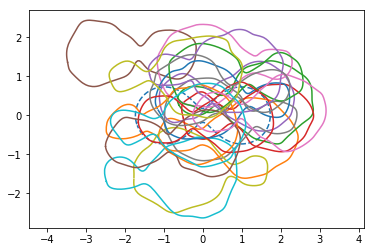

In [4]:
plt.plot(template[:, 0].numpy(), template[:, 1].numpy(), '--')
for p in peanuts:
    plt.plot(p[:, 0].numpy(), p[:, 1].numpy())
plt.axis('equal')
plt.show()

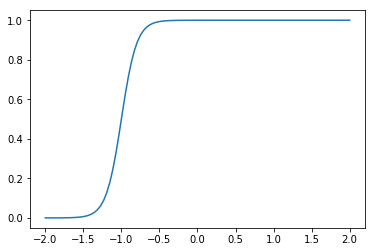

In [5]:
X = torch.linspace(-2., 2., 100)
Y = torch.sigmoid(10 * (X + 1) )
plt.figure()
plt.plot(X.numpy(), Y.numpy(), '-')

In [6]:
def sigmoid(pos, trans0, trans1, lambda0, lambda1):
    C = torch.zeros(pos.shape[0], 2, 2)
    C[:, 0, 0] = torch.sigmoid(lambda0**2*(pos[:, 0]+trans0))
    C[:, 1, 0] = torch.sigmoid(lambda0**2*(pos[:, 0]+trans0))
    C[:, 0, 1] = torch.sigmoid(-lambda1**2*(pos[:, 0]+trans1))
    C[:, 1, 1] = torch.sigmoid(-lambda1**2*(pos[:, 0]+trans1))
    return C
    #modules[2].coeff = 100.*math.exp(-0.01*cur_it)

In [7]:
aabb_template = dm.Utilities.AABB.build_from_points(template)
aabb_template.scale(2.)
aabb_total = dm.Utilities.AABB.build_from_points(torch.cat(peanuts))

density = 15
sigma = 2/math.sqrt(density)

area = lambda x, **kwargs: dm.Utilities.area_shape(x, shape=template, side=1) | dm.Utilities.area_polyline_outline(x, polyline=template, width=sigma)

pts_implicit1 = dm.Utilities.fill_area_uniform_density(area, aabb_template, density, shape=template, side=1)
print(pts_implicit1.shape)
angles = 0. * math.pi * torch.ones(pts_implicit1.shape[0])
R = torch.stack([dm.Utilities.rot2d(a) for a in angles])

torch.Size([142, 2])


In [8]:
pts_implicit1[:5]

tensor([[-2.1684, -0.4311],
        [-2.1684, -0.1729],
        [-2.1684,  0.0853],
        [-2.1684,  0.3435],
        [-1.9102, -0.6893]])

In [9]:
sigma

0.5163977794943222

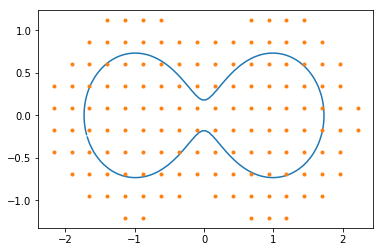

In [10]:
plt.plot(template[:, 0].numpy(), template[:, 1].numpy())
plt.plot(pts_implicit1[:, 0].numpy(), pts_implicit1[:, 1].numpy(), '.')
plt.show()

In [11]:
load_abc = False
if not load_abc:
    abc = torch.zeros(2, 2)
    abc[0] = torch.tensor([-0.5, 0.5])
    abc[1] = 4.*torch.tensor([1., 1.])
else:
    abc = torch.tensor(pickle.load(open("saved_coef.pickle", 'rb')))

print(abc)

C = sigmoid(pts_implicit1, abc[0, 0], abc[0, 1], abc[1, 0], abc[1, 1])

abc.requires_grad_()

implicit1 = dm.DeformationModules.ImplicitModule1.build_and_fill(2, pts_implicit1.shape[0], C, sigma, 0.001, coeff=0.5, gd=(pts_implicit1.view(-1).requires_grad_(), R.view(-1).requires_grad_()))

tensor([[-0.5000,  0.5000],
        [ 4.0000,  4.0000]])


In [12]:
%matplotlib qt5

ax = plt.subplot(1, 2, 1)
plt.plot(template[:, 0].numpy(), template[:, 1].numpy())
dm.Utilities.plot_C_ellipse(ax, pts_implicit1, C.detach().numpy(), c_index=0, scale=.5)
plt.axis('equal')
ax = plt.subplot(1, 2, 2)
plt.plot(template[:, 0].numpy(), template[:, 1].numpy())
dm.Utilities.plot_C_ellipse(ax, pts_implicit1, C.detach().numpy(), c_index=1, scale=.5)
plt.axis('equal')
plt.show()

In [13]:
sigma0 = 0.2
nu0 = 0.01
implicit0 = dm.DeformationModules.ImplicitModule0.build_from_points(2, template.shape[0], sigma0, nu0, coeff=2., gd=template.view(-1).requires_grad_())

In [14]:

def myParametricModel(init_manifold, modules, parameters):
    param = parameters[-1]
    trans = param[0]
    lambdas = param[1]
    pos = modules[1].manifold.gd[0].detach().view(-1, 2)
    modules[1]._ImplicitModule1__C = sigmoid(pos, trans[0], trans[1], lambdas[0], lambdas[1])


In [15]:
abc

tensor([[-0.5000,  0.5000],
        [ 4.0000,  4.0000]], requires_grad=True)

In [16]:
my_atlas = dm.Models.Atlas(template, [implicit1, dm.DeformationModules.GlobalTranslation(2)], [dm.Attachment.VarifoldAttachement([0.2, 1., 5.])], len(peanuts), lam=10., model_precompute_callback=myParametricModel, other_parameters=[abc], optimise_template=False)

In [17]:
shoot_it = 10
shoot_method = 'euler'

In [18]:
cur_it = 0
def post_iteration_callback(model):
    global cur_it
    cur_it = cur_it + 1
    print(model.parameters[-1])
    
#def post_iteration_callback(model):
#    print(model.parameters[-1])
    
    
fitter = dm.Models.ModelFittingScipy(my_atlas, 1., post_iteration_callback=post_iteration_callback)
bounds = [(None, None)]*fitter.vector_size()
bounds[-4] = (-1., 1.)
bounds[-3] = (-1., 1.)


In [19]:
costs = fitter.fit(peanuts, 400, options={'shoot_it': shoot_it, 'shoot_method': shoot_method, 'bounds': bounds }, log_interval=1)
#costs = fitter.fit(peanuts, 400, options={'shoot_it': shoot_it, 'shoot_method': shoot_method}, log_interval=1)

Initial energy = 3669.634
tensor([[-0.5000,  0.5000],
        [ 4.0000,  4.0000]], requires_grad=True)
Iteration: 1 
Total energy = 1559.510986 
Attach cost = 1550.784912 
Deformation cost = 8.726222
tensor([[-0.5000,  0.5000],
        [ 4.0000,  4.0000]], requires_grad=True)
Iteration: 2 
Total energy = 1245.463745 
Attach cost = 1231.513062 
Deformation cost = 13.950773
tensor([[-0.5000,  0.5000],
        [ 4.0000,  4.0000]], requires_grad=True)
Iteration: 3 
Total energy = 1086.017822 
Attach cost = 1072.271362 
Deformation cost = 13.746433
tensor([[-0.5000,  0.5000],
        [ 4.0000,  4.0000]], requires_grad=True)
Iteration: 4 
Total energy = 973.955688 
Attach cost = 960.422852 
Deformation cost = 13.532824
tensor([[-0.5000,  0.5000],
        [ 4.0000,  4.0000]], requires_grad=True)
Iteration: 5 
Total energy = 939.122192 
Attach cost = 925.164185 
Deformation cost = 13.958121
tensor([[-0.5000,  0.5000],
        [ 4.0000,  4.0000]], requires_grad=True)
Iteration: 6 
Total energy 

tensor([[-0.4720,  0.5734],
        [ 4.0108,  3.9958]], requires_grad=True)
Iteration: 34 
Total energy = 898.956970 
Attach cost = 868.430847 
Deformation cost = 30.526247
tensor([[-0.4720,  0.5728],
        [ 4.0106,  3.9958]], requires_grad=True)
Iteration: 35 
Total energy = 898.421631 
Attach cost = 868.161255 
Deformation cost = 30.260437
tensor([[-0.4708,  0.5751],
        [ 4.0109,  3.9956]], requires_grad=True)
Iteration: 36 
Total energy = 898.398743 
Attach cost = 866.984802 
Deformation cost = 31.414104
tensor([[-0.4705,  0.5757],
        [ 4.0110,  3.9956]], requires_grad=True)
Iteration: 37 
Total energy = 898.277649 
Attach cost = 866.550842 
Deformation cost = 31.726761
tensor([[-0.4705,  0.5758],
        [ 4.0110,  3.9955]], requires_grad=True)
Iteration: 38 
Total energy = 898.248962 
Attach cost = 866.481201 
Deformation cost = 31.767776
tensor([[-0.4703,  0.5760],
        [ 4.0110,  3.9955]], requires_grad=True)
Iteration: 39 
Total energy = 898.229004 
Attach cost

In [12]:
print(torch.tensor(pickle.load(open("saved_coef.pickle", 'rb'))))
print(my_atlas.parameters[-1])

tensor([[ 1.0000,  1.0000],
        [-0.5000,  0.5000],
        [ 4.0000,  4.0000]])
tensor([[ 1.0000,  1.0000],
        [-0.5060,  0.4382],
        [ 3.9980,  3.9885]], requires_grad=True)


In [ ]:
pickle.dump(my_atlas.parameters[-1].detach().tolist(), open("saved_coef.pickle", 'wb'))

In [19]:
plt.plot(range(len(costs)), costs)
plt.show()

In [ ]:
C_gt = torch.ones(pts_implicit1.shape[0], 2, 1)
C_gt[:, 0 , 0] = 1.*(pts_implicit1[:, 0]+torch.min(pts_implicit1[:, 0]))

In [22]:
%matplotlib qt5
ax = plt.subplot(1, 2, 1)
plt.plot(template[:, 0].numpy(), template[:, 1].numpy())
dm.Utilities.plot_C_ellipse(ax, pts_implicit1, implicit1.C.detach(), c_index=0, alpha=0.3, scale=0.5, color='blue')
#dm.Utilities.plot_C_arrow(ax, pts_implicit1, C_gt, alpha=0.3, scale=0.3, color='red', mutation_scale=5.)
plt.axis('equal')

ax = plt.subplot(1, 2, 2)
plt.plot(template[:, 0].numpy(), template[:, 1].numpy())
dm.Utilities.plot_C_ellipse(ax, pts_implicit1, implicit1.C.detach(), c_index=1, alpha=0.3, scale=0.5,  color='blue')
#dm.Utilities.plot_C_ellipse(ax, pts_implicit1, C_gt, c_index=1, alpha=0.1, scale=0.01, color='C2')
plt.axis('equal')
plt.show()

In [24]:
%matplotlib qt5
it_per_snapshot = 1
snapshots = int(shoot_it/it_per_snapshot)

#ht = my_atlas.compute_template().detach().view(-1, 2)

N = 10

for i in range(N):
    aabb_target = dm.Utilities.AABB.build_from_points(peanuts[i])
    modules = dm.DeformationModules.CompoundModule(my_atlas.models[i].modules)
    modules.manifold.fill(my_atlas.models[i].init_manifold, copy=True)
    h = dm.HamiltonianDynamic.Hamiltonian(modules)
    intermediate_states, _ = dm.HamiltonianDynamic.shoot(h, shoot_it, shoot_method, intermediates=True)

    for j in range(snapshots):
        pos = intermediate_states[it_per_snapshot*j].gd[0].view(-1, 2).numpy()
        pos_impl1 = intermediate_states[it_per_snapshot*j].gd[1][0].view(-1, 2).numpy()
        plt.subplot(N, snapshots + 1, i*snapshots + j + i + 1)
        plt.plot(pos[:, 0], pos[:, 1])
        #plt.plot(pos_impl1[:, 0], pos_impl1[:, 1], '.')
        plt.axis("equal")
        plt.axis(aabb_target.get_list())


    plt.subplot(N, snapshots + 1, i*snapshots + snapshots + i + 1)
    plt.plot(peanuts[i].numpy()[:, 0], peanuts[i].numpy()[:, 1])
    plt.axis("equal")
    plt.axis(aabb_target.get_list())